In [23]:
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext, SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import cm
import numpy as np

In [24]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext.getOrCreate(spark.sparkContext)

In [25]:
sc = SparkSession.builder.appName("PysparkExample").config ("spark.sql.shuffle.partitions", "50").config("spark.driver.maxResultSize","5g").config ("spark.sql.execution.arrow.enabled", "true").getOrCreate()

In [26]:
news_df = sqlContext.read.csv(r'C:\Users\Junji\Documents\GitHub\team-mount-elbert\news.csv', header=True)

In [27]:
news_df.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|        publish_date|         description|                text|                 url|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|        ['Cbc News']|Coronavirus a 'wa...|      3/27/2020 8:00|Canadian pharmaci...|"Canadian pharmac...|"" he said.  Tadr...|
|  1|        ['Cbc News']|Yukon gov't names...|      3/27/2020 1:45|The Yukon governm...|"The Yukon govern...|  from March 9 to 13|
|  2|['The Associated ...|U.S. Senate passe...|      3/26/2020 5:13|The Senate has pa...|"The Senate late ...|"" said Democrati...|
|  3|        ['Cbc News']|Coronavirus: The ...|      3/27/2020 0:36|Scientists around...|"Scientists aroun...| "" said Zarychanski|
|  4|        ['Cbc News']|The latest on the...|     3/26/2020 20:57|The late

In [28]:
#clean columns, remove smybols
from pyspark.sql.functions import *
def cleanColumn(tmpdf,colName,findChar,replaceChar):
    tmpdf = tmpdf.withColumn(colName, regexp_replace(colName, findChar, replaceChar))
    return tmpdf

allColNames = news_df.schema.names
charToRemove= "[\"!@#$%^&*\(\)\{\}\[\]\'\'""',.?/:;-=+`~'...''..']"
replaceWith =""
for colName in allColNames:
    news_df=cleanColumn(news_df,colName,charToRemove,replaceWith)

In [29]:
news_df.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|        publish_date|         description|                text|                 url|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|  1|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|  2|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|  3|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|  4|            Cbc News|The latest on the...|        3262020 2057|The late

In [30]:
#drop column _c0
news_df = news_df.drop('_c0')
news_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|        publish_date|         description|                text|                 url|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|            Cbc News|The latest on the...|        3262020 2057|The latest on the...|    Trudeau says ..

In [31]:
#drop rows with NAs/ Null values
def dropNA (tmpdf2,columnName):
    tmpdf2 = tmpdf2.where(col(columnName).isNotNull())
    return tmpdf2

columnName = ["authors","title","publish_date","description","text","url"]
allColNames2 = news_df.schema.names

for columnName in allColNames2:
    news_df = dropNA(news_df,columnName)

In [32]:
news_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|        publish_date|         description|                text|                 url|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|            Cbc News|The latest on the...|        3262020 2057|The latest on the...|    Trudeau says ..

In [33]:
# print schema to know what to query against
news_df.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [34]:
#create tmp table view
news_df.createOrReplaceTempView("count_table")

In [35]:
#count # of authors
filtered_count_df = spark.sql("SELECT COUNT (DISTINCT authors) AS Author_Count FROM count_table")
filtered_count_df.show()

+------------+
|Author_Count|
+------------+
|         261|
+------------+



In [36]:
#groupby publish_date to see how many articles were published daily and by time stamp
news_df.groupBy("publish_date").count().show()

+------------+-----+
|publish_date|count|
+------------+-----+
|3202020 2001|    1|
|3262020 1805|    1|
| 2242020 900|    1|
|2272020 1322|    1|
|2292020 1000|    3|
|3262020 2300|    2|
|2182020 2055|    1|
| 2202020 057|    1|
|  282020 529|    1|
|1302020 1343|    1|
|1292020 1709|    1|
| 1112020 357|    1|
| 3262020 241|    1|
|3252020 1740|    1|
|3232020 1701|    1|
|3242020 2242|    1|
|3212020 1930|    1|
| 3192020 900|    4|
|3202020 1806|    1|
|3232020 1400|    2|
+------------+-----+
only showing top 20 rows



In [37]:
# groupby and count # of authors
news_df.groupBy("authors").count().show()

+--------------------+-----+
|             authors|count|
+--------------------+-----+
|Senior Writer Pet...|   10|
|Andrea Bellemare ...|    4|
|Briar Stewart Is ...|    1|
|Business Columnis...|    9|
|Joel Joined Cbc C...|    1|
|Lucie Edwardson I...|    3|
|Nic Meloney Is A ...|    1|
|Enterprise Report...|    1|
|Janet French Is A...|    2|
|Brittany Spencer ...|    1|
|Business Reporter...|   15|
|Drew Anderson Is ...|    8|
|Host London Morni...|    1|
|Carolyn Ray Is A ...|    3|
|Jim Agapito Is A ...|    1|
|Cbc News David Co...|    1|
|Reporter Cbc Toro...|    4|
|Entertainment Rep...|    2|
|Jennifer Sweet Is...|    3|
|Jason Warick Is A...|    6|
+--------------------+-----+
only showing top 20 rows



In [38]:
# groupby and count # of titles, shows duplicate titles
news_df.groupBy("title").count().show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|Arizona man dead ...|    1|
|Michigan governor...|    1|
|TSX and Dow make ...|    1|
|How one Windsor r...|    1|
|Coronavirus delay...|    1|
|Alberta couple ab...|    1|
|COVID-19 backlog ...|    1|
|Pace of COVID-19 ...|    1|
|Chinas coronaviru...|    1|
|More artists post...|    1|
|Sudbury doctor sa...|    1|
|1 in 3 Canadians ...|    1|
|    MERS coronavirus|    1|
|Manitoba stylists...|    1|
|Tremendously dang...|    1|
| You Can Email Hi...|    1|
|What pregnant wom...|    1|
|No privacy review...|    1|
|More than 50 nurs...|    2|
|Stranded abroad W...|    2|
+--------------------+-----+
only showing top 20 rows



In [39]:
# groupby and count # of description shows duplicate descriptions
news_df.groupBy("description").count().show()

+--------------------+-----+
|         description|count|
+--------------------+-----+
|The state of Mich...|    1|
|US President Dona...|    1|
|Licensed daycare ...|    1|
|A case of the nov...|    1|
|The European Spac...|    1|
|Effective Saturda...|    1|
|Cruise ships have...|    1|
|School trips are ...|    1|
|The Toronto Stock...|    2|
|McMaster Universi...|    1|
|Travel and touris...|    1|
|Ottawa Public Hea...|    1|
|Alberta has boost...|    1|
|Provincial health...|    1|
|Health officials ...|    1|
|Economists are bu...|    2|
|An outbreak of co...|    1|
|Ontario has rough...|    2|
|An employee who s...|    1|
|An early forecast...|    1|
+--------------------+-----+
only showing top 20 rows



In [40]:
# groupby and count # of url shows duplicate descriptions
news_df.groupBy("url").count().show()

+--------------------+-----+
|                 url|count|
+--------------------+-----+
|httpswwwcbccanews...|    1|
| Johnson said in ...|    1|
|         restaurants|    1|
|  they are empowered|    1|
|httpswwwcbccanews...|    1|
| said Leung on Th...|    1|
| and is currently...|    1|
| said Dr Bonnie H...|    1|
|    said David Musyj|    1|
|            hamsters|    1|
| said Anita Huberman|    2|
|New Brunswicks ch...|    1|
| Kenney said Mond...|    1|
| Vienneau told CB...|    1|
| which is sort of...|    1|
|    said Yoko Haneda|    1|
| and the health c...|    1|
| Vancouver and Mo...|    1|
| we do not antici...|    1|
| Ottawa city mana...|    1|
+--------------------+-----+
only showing top 20 rows



In [41]:
#Stop word removal code from DataCamp
# Create a baseRDD from the file path
sc = spark.sparkContext

baseRDD = sc.textFile(r"C:\Users\Junji\Documents\GitHub\team-mount-elbert\news.csv")

# Split the lines of baseRDD into words
splitRDD = baseRDD.flatMap(lambda x: x.split())

# Count the total number of words
print("Total number of words in splitRDD:", splitRDD.count())

Total number of words in splitRDD: 2734102


In [42]:
stop_words = ['whence', 'here', 'show', 'were', 'why', 'n’t', 'the', 'whereupon', 'not', 'more', 'how', 'eight', 'indeed', 
              'i', 'only', 'via', 'nine', 're', 'themselves', 'almost', 'to', 'already', 'front', 'least', 'becomes', 
              'thereby', 'doing', 'her', 'together', 'be', 'often', 'then', 'quite', 'less', 'many', 'they', 'ourselves', 
              'take', 'its', 'yours', 'each', 'would', 'may', 'namely', 'do', 'whose', 'whether', 'side', 'both', 'what', 
              'between', 'toward', 'our', 'whereby', "'m", 'formerly', 'myself', 'had', 'really', 'call', 'keep', "'re", 
              'hereupon', 'can', 'their', 'eleven', '’m', 'even', 'around', 'twenty', 'mostly', 'did', 'at', 'an', 'seems', 
              'serious', 'against', "n't", 'except', 'has', 'five', 'he', 'last', '‘ve', 'because', 'we', 'himself', 'yet', 
              'something', 'somehow', '‘m', 'towards', 'his', 'six', 'anywhere', 'us', '‘d', 'thru', 'thus', 'which', 
              'everything', 'become', 'herein', 'one', 'in', 'although', 'sometime', 'give', 'cannot', 'besides', 'across', 
              'noone', 'ever', 'that', 'over', 'among', 'during', 'however', 'when', 'sometimes', 'still', 'seemed', 'get', 
              "'ve", 'him', 'with', 'part', 'beyond', 'everyone', 'same', 'this', 'latterly', 'no', 'regarding', 'elsewhere', 
              'others', 'moreover', 'else', 'back', 'alone', 'somewhere', 'are', 'will', 'beforehand', 'ten', 'very', 'most', 
              'three', 'former', '’re', 'otherwise', 'several', 'also', 'whatever', 'am', 'becoming', 'beside', '’s', 'nothing', 
              'some', 'since', 'thence', 'anyway', 'out', 'up', 'well', 'it', 'various', 'four', 'top', '‘s', 'than', 'under', 'might', 
              'could', 'by', 'too', 'and', 'whom', '‘ll', 'say', 'therefore', "'s", 'other', 'throughout', 'became', 'your', 'put', 'per', 
              "'ll", 'fifteen', 'must', 'before', 'whenever', 'anyone', 'without', 'does', 'was', 'where', 'thereafter', "'d", 'another', 
              'yourselves', 'n‘t', 'see', 'go', 'wherever', 'just', 'seeming', 'hence', 'full', 'whereafter', 'bottom', 'whole', 'own', 
              'empty', 'due', 'behind', 'while', 'onto', 'wherein', 'off', 'again', 'a', 'two', 'above', 'therein', 'sixty', 'those', 
              'whereas', 'using', 'latter', 'used', 'my', 'herself', 'hers', 'or', 'neither', 'forty', 'thereupon', 'now', 'after', 
              'yourself', 'whither', 'rather', 'once', 'from', 'until', 'anything', 'few', 'into', 'such', 'being', 'make', 'mine', 
              'please', 'along', 'hundred', 'should', 'below', 'third', 'unless', 'upon', 'perhaps', 'ours', 'but', 'never', 'whoever', 
              'fifty', 'any', 'all', 'nobody', 'there', 'have', 'anyhow', 'of', 'seem', 'down', 'is', 'every', '’ll', 'much', 'none', 
              'further', 'me', 'who', 'nevertheless', 'about', 'everywhere', 'name', 'enough', '’d', 'next', 'meanwhile', 'though', 
              'through', 'on', 'first', 'been', 'hereby', 'if', 'move', 'so', 'either', 'amongst', 'for', 'twelve', 'nor', 'she', 'always', 
              'these', 'as', '’ve', 'amount', '‘re', 'someone', 'afterwards', 'you', 'nowhere', 'itself', 'done', 'hereafter', 'within', 
              'made', 'ca', 'them', 'said', 'said.', '— has', 'says', '— has', '—','""We']

In [43]:
# Convert the words in lower case and remove stop words from stop_words
splitRDD_no_stop = splitRDD.filter(lambda x: x.lower() not in stop_words)

# Create a tuple of the word and 1 
splitRDD_no_stop_words = splitRDD_no_stop.map(lambda w: (w, 1))

# Count of the number of occurences of each word 
resultRDD = splitRDD_no_stop_words.reduceByKey(lambda x, y: x + y)

In [44]:
# Swap the keys and values
resultRDD_swap = resultRDD.map(lambda x: (x[1], x[0]))

# Sort the keys in descending order
resultRDD_swap_sort = resultRDD_swap.sortByKey(ascending=False)

# Show the top 10 most frequent words and their frequencies
for word in resultRDD_swap_sort.take(10):
	print("{} has {} counts". format(word[1], word[0]))

COVID-19 has 12123 counts
people has 11326 counts
health has 8979 counts
coronavirus has 7697 counts
cases has 6950 counts
new has 5099 counts
public has 4953 counts
Health has 4927 counts
government has 4434 counts
Canada has 4396 counts


In [45]:
new_results_df = spark.createDataFrame(resultRDD_swap_sort)
new_results_df.createOrReplaceTempView("Word_Count")

In [46]:
data = new_results_df.select(col("_1").alias("count"), col("_2").alias("word"))

In [47]:
data.show()

+-----+-----------+
|count|       word|
+-----+-----------+
|12123|   COVID-19|
|11326|     people|
| 8979|     health|
| 7697|coronavirus|
| 6950|      cases|
| 5099|        new|
| 4953|     public|
| 4927|     Health|
| 4434| government|
| 4396|     Canada|
| 3874|     spread|
| 3701|       need|
| 3657|       home|
| 3563|  confirmed|
| 3328|      virus|
| 3302|      March|
| 3279|       it's|
| 3228|   province|
| 3006|  officials|
| 2966|       ""We|
+-----+-----------+
only showing top 20 rows



In [48]:
top_10 = data.take(10)
top_10

[Row(count=12123, word='COVID-19'),
 Row(count=11326, word='people'),
 Row(count=8979, word='health'),
 Row(count=7697, word='coronavirus'),
 Row(count=6950, word='cases'),
 Row(count=5099, word='new'),
 Row(count=4953, word='public'),
 Row(count=4927, word='Health'),
 Row(count=4434, word='government'),
 Row(count=4396, word='Canada')]

In [49]:
pdDF = pd.DataFrame(data.take(15), columns=data.columns)
pdDF

,count,word
0,12123,COVID-19
1,11326,people
2,8979,health
3,7697,coronavirus
4,6950,cases
5,5099,new
6,4953,public
7,4927,Health
8,4434,government
9,4396,Canada


<Figure size 432x288 with 0 Axes>

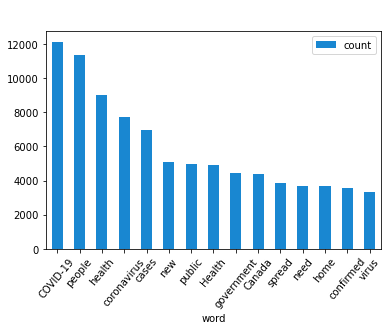

In [50]:
#color = cm.PuRd_r(np.linspace(.1, .4, 20))
plt.clf()
pdDF.plot(x='word',  y='count', kind='bar', color='#007acc', alpha=0.9, linewidth=5, rot=50)
plt.title("Covid-19 Word Count", color='w', fontsize=25)
display()

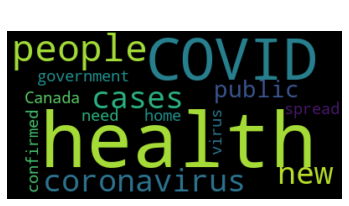

In [51]:
wordcloud = WordCloud().generate(' '.join(pdDF['word']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Covid-19 Word Cloud", color='w', fontsize=25)
plt.show()

In [53]:
from textblob import TextBlob
import seaborn as sns

In [54]:
pandas_df = news_df.toPandas()
pandas_df_noNA = pandas_df[pandas_df['authors'].notna()]
pandas_df_noNA

,authors,title,publish_date,description,text,url
0,Cbc News,Coronavirus a wake-up call for Canadas prescri...,3272020 800,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,he said Tadrous said pharmacies get their me...
1,Cbc News,Yukon govt names 2 possible sources of coronav...,3272020 145,The Yukon government has identified two places...,The Yukon government has identified two places...,from March 9 to 13
2,The Associated Press,US Senate passes 2T coronavirus relief package,3262020 513,The Senate has passed an unparalleled 22 trill...,The Senate late Wednesday passed an unparallel...,said Democratic Senate Minority Leader Chuck ...
3,Cbc News,Coronavirus The latest in drug treatment and v...,3272020 036,Scientists around the world are racing to find...,Scientists around the world are racing to find...,said Zarychanski
4,Cbc News,The latest on the coronavirus outbreak for Mar...,3262020 2057,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,Prime Minister Justin Trudeau said today
...,...,...,...,...,...,...
3560,The Associated Press,South Korea declares end to MERS virus outbreak,12232015 907,South Korea on Wednesday declared a formal end...,South Korea on Wednesday declared a formal end...,httpswwwcbccanewshealthkorea-mers-outbreak-ove...
3561,The Canadian Press,MERS virus spread in hospitals should be focus...,1282014 1607,The spread of MERS coronavirus infections in h...,The spread of MERS coronavirus infections in h...,the frequent movement of patients
3562,Cbc News,Ellershausen Manor is for sale,1122012 124,A clasic old home with a lot of history in now...,Its a relic of a bygone era when wealthy Nova ...,httpswwwcbccanewscanadanova-scotiaellershausen...
3563,Cbc News,MERS virus from camels and humans called indis...,4292014 1657,Camels have been implicated in a Middle Easter...,Camels have been implicated in a Middle Easter...,these findings support the plausibility of a ...


In [55]:
text_sample = pandas_df[['authors','text']].sample(1000)
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity
text_sample['polarity'] = text_sample.text.apply(detect_polarity)
text_sample.head(100)

,authors,text,polarity
3307,,A Prince George woman originally from Wuhan Ch...,0.037500
1035,Reporter Editor Bobhristova Is A Reporter Edit...,Quinn Talukdar dreamed about getting into the ...,-0.106250
1371,,Halifaxs alternative weekly newspaper is halti...,0.000000
2941,,Transcona councillor Shawn Nason abruptly left...,-0.050000
940,,Ottawas mayor has declared a state of emergenc...,0.477778
...,...,...,...
2706,,As the region continues its response to COVID-...,0.000000
1373,The Canadian Press,Prime Minister Justin Trudeau says the federal...,-0.062500
696,Cbc News,Good morning This is our daily news roundup wi...,0.107895
156,Cbc News,Alberta has reported 23 new cases of COVID-19 ...,0.000710


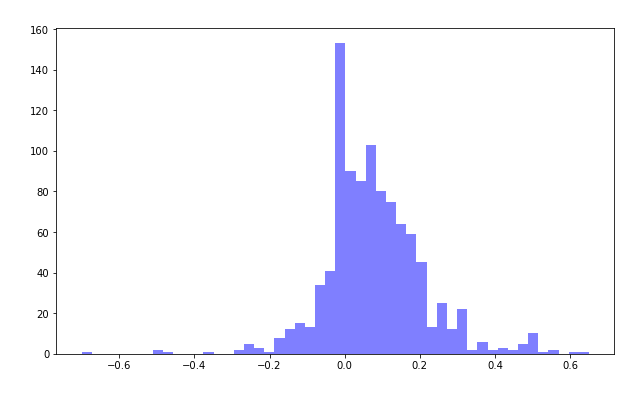

In [56]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(text_sample.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity', color='w', fontsize=20)
plt.ylabel('Count', color='w', fontsize=20)
plt.title('Histogram of Polarity for Covid-19 News Articles', color='w', fontsize=20)
plt.show(); 

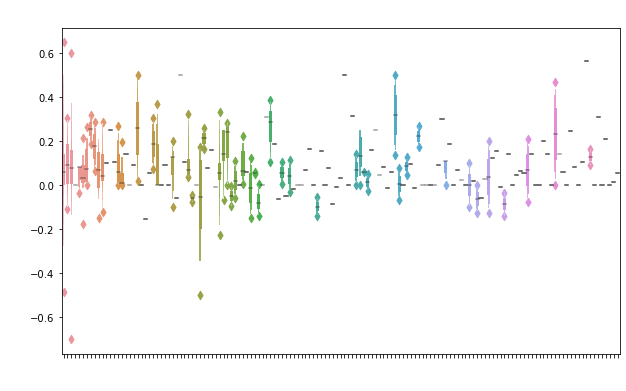

In [57]:
plt.figure(figsize=(10,6))
chart = sns.boxenplot(x='authors', y='polarity', data=text_sample)
plt.xlabel('Authors', color='w', fontsize=20)
plt.ylabel('Polarity', color='w', fontsize=20)
plt.title('Boxplot of Polarity for Covid-19 by Authors', color='w', fontsize=20)
chart.set(xticklabels=[])
plt.show(); 